Parse failures tree map analysis and top 10 stack traces per parser

In [1]:
import plotly.express as px
import pandas as pd
from code_data_science import data_table as dt, data_grid as moderne_data_grid
import code_data_science.palette as palette
import re
from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.set_option('expand_frame_repr',True)
df = dt.read_csv("../samples/parse_failure_kotlin.csv")

df.dropna(subset=['stackTrace'])
df['stackTrace'] = df['stackTrace'].astype(str)

parser_series = df["parser"]
stack_trace_series = df['stackTrace']
stack_trace_lines_list = [trace.split('\n') for trace in stack_trace_series]

pattern = re.compile(r'\((.*?)\)')

formatted_stack_trace_series = []
for stack_trace_lines in stack_trace_lines_list:
    formatted_trace = []
    i = 0
    for line in stack_trace_lines:
        if i >= 3:
            break
        
        match = pattern.search(line)
        if match:
            extracted_content = match.group(1)
            formatted_trace.append(extracted_content)
            i = i + 1
    formatted_stack_trace_series.append('\n'.join(formatted_trace))


df = pd.DataFrame({
    "parser": parser_series,
    "stackTrace": stack_trace_series
    })
df["formattedStackTrace"] = formatted_stack_trace_series
df['first5Lines'] = df['stackTrace'].str.split('\n').str[:5].str.join('\n')


df_grouped = df.groupby(by=["parser", "formattedStackTrace"], as_index=False).size()
df_grouped["first5Lines"] = df.groupby(by=["parser", "formattedStackTrace"])["first5Lines"].first().values
df_grouped.rename(columns={"size": "count"}, inplace=True)
# df_grouped["formattedStackTrace"] = df_grouped["first5Lines"]


df_grouped["name"] = " Count: " + df_grouped["count"].astype(str) + ", Stack Trace Position: " + df_grouped["formattedStackTrace"].astype(str)

# Set the color palette
colors = palette.qualitative()

fig = px.treemap(
    df_grouped,
    path=["parser", "name"],
    values="count",
    title='TreeMap of Stack Trace Counts',
    color_discrete_sequence=colors,
)


fig.update_traces(textfont=dict(size=12))
fig.show()



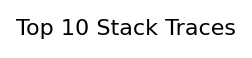

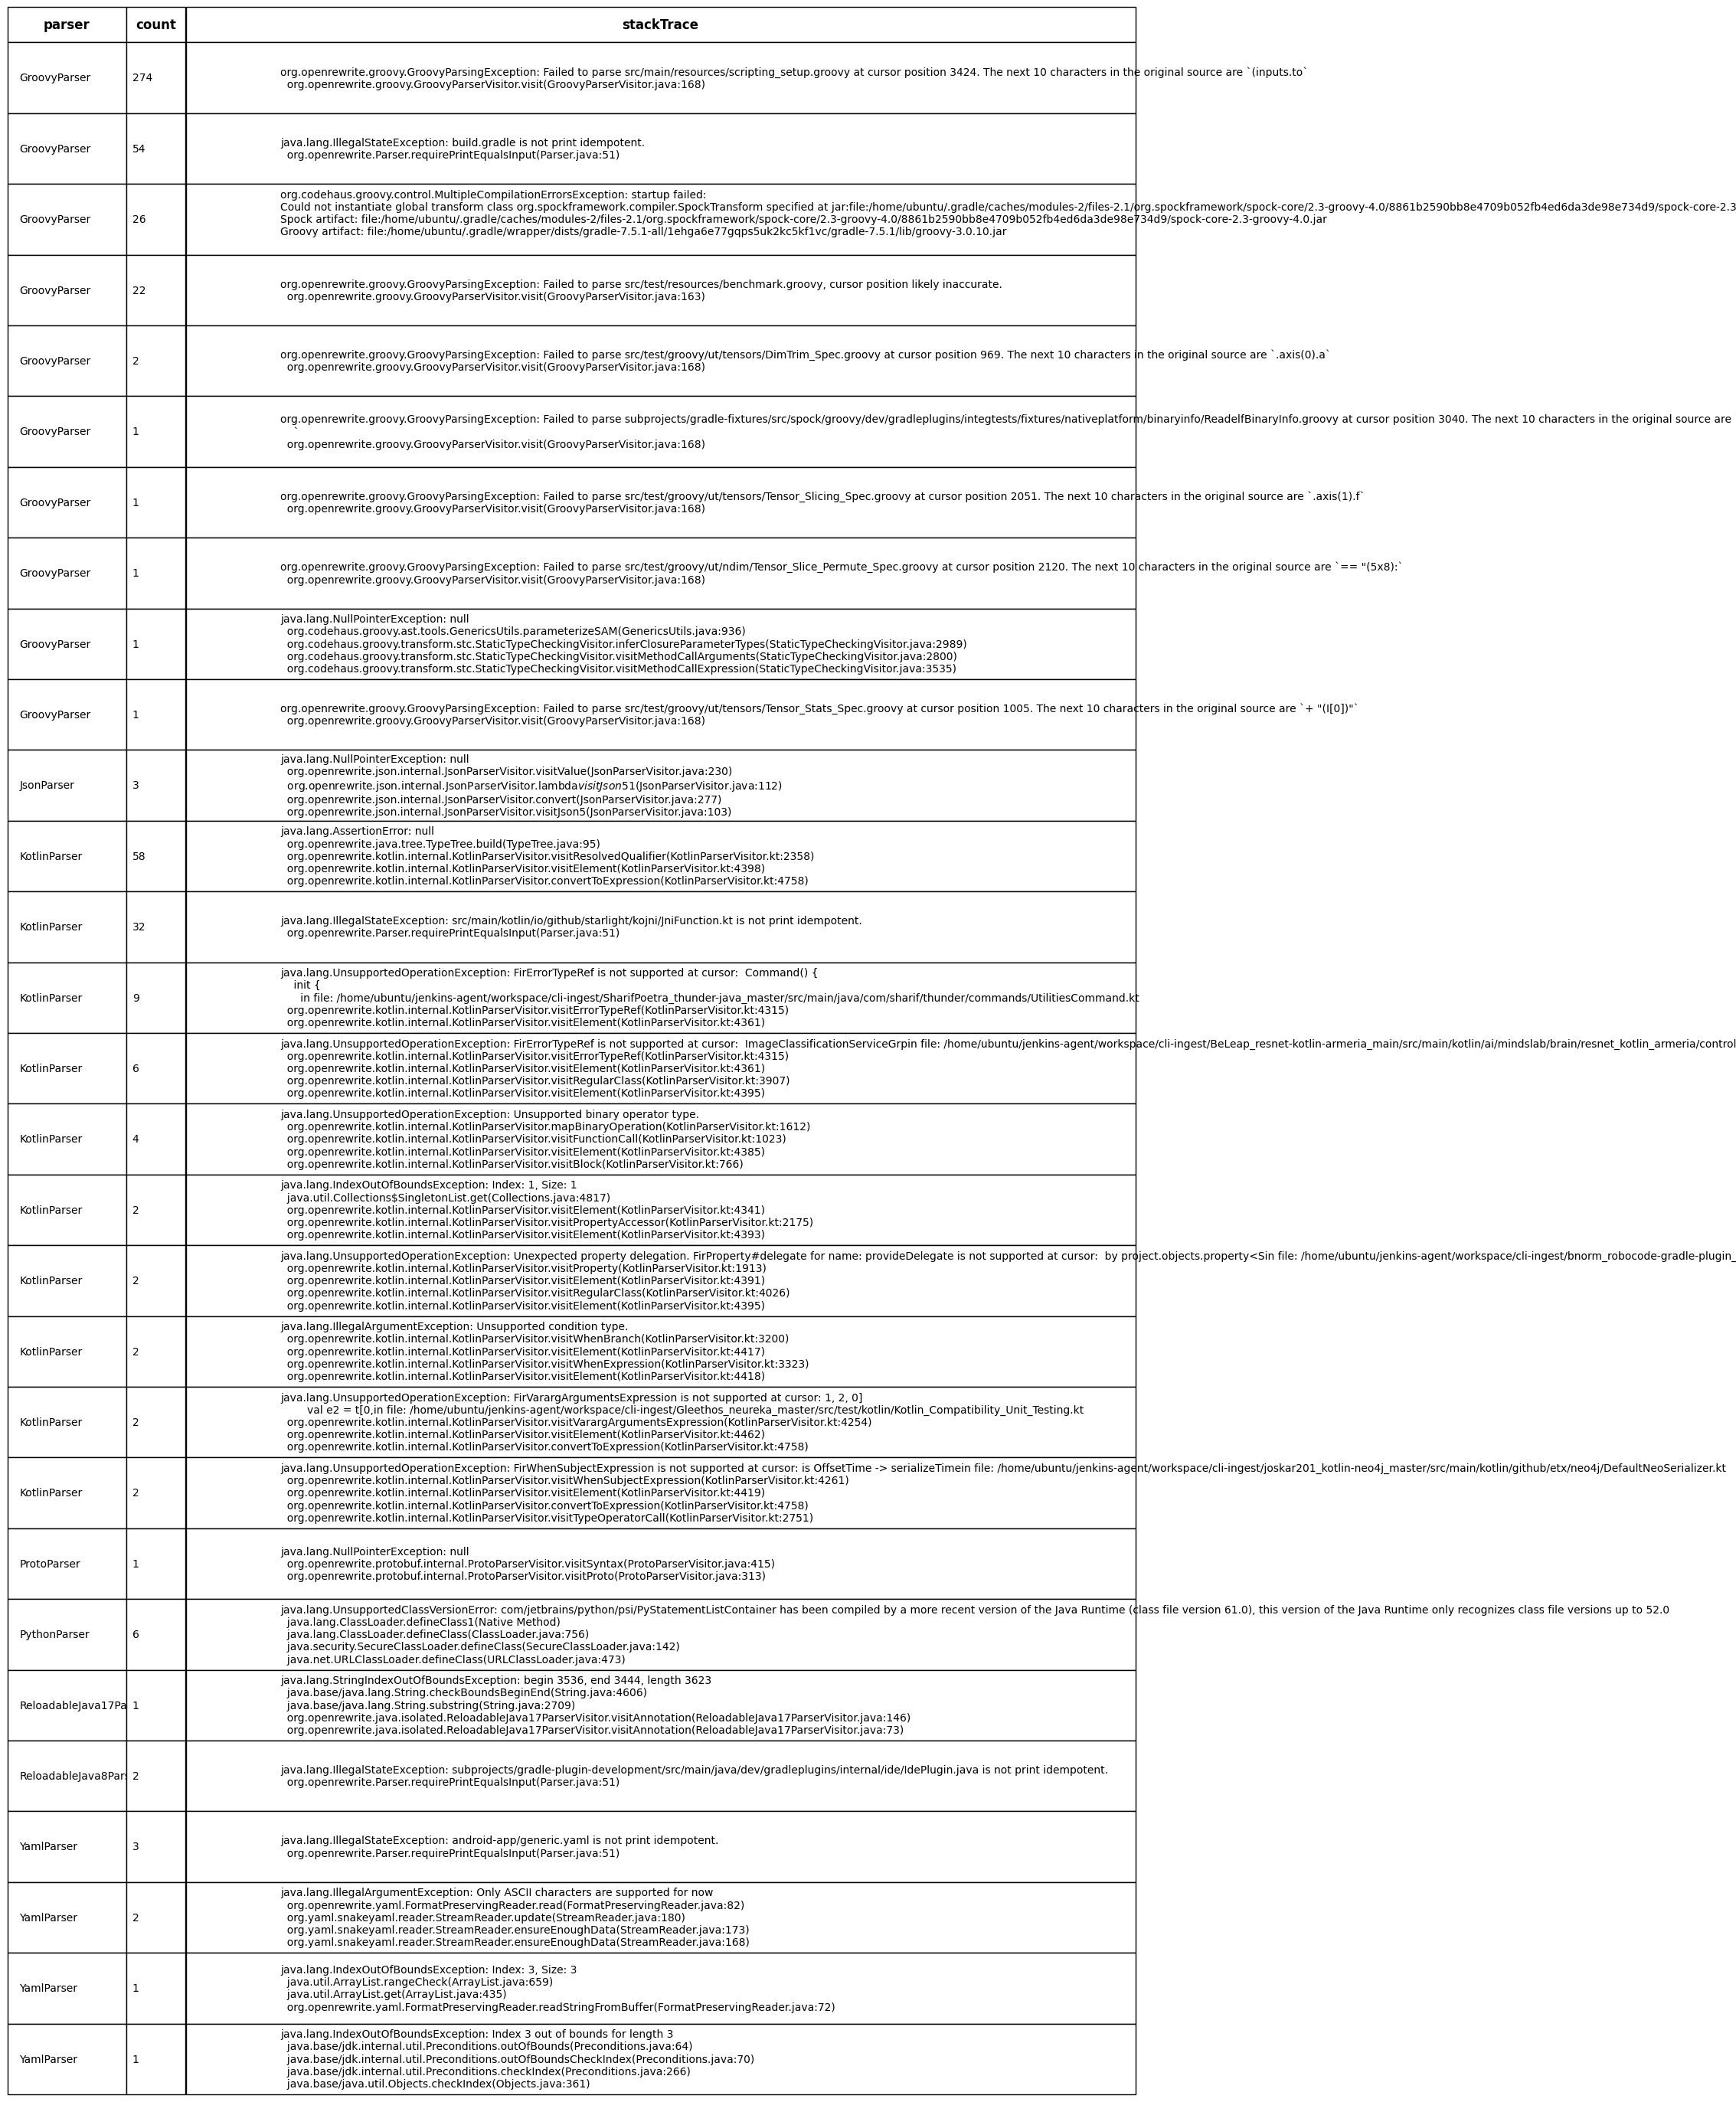

In [2]:
# Display "Top 10 Stack Traces"
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3,0.5))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

text = "Top 10 Stack Traces"
fontsize = 16
ax.text(0.5, 0.5, text, fontsize=fontsize, ha='center', va='center')
ax.axis('off')

plt.show()


#Display top 10 stack traces
import matplotlib.pyplot as plt

top_10_stacktraces = df_grouped.groupby('parser').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)

top_10_stacktraces['stackTrace'] = top_10_stacktraces['first5Lines'] # .str.replace('\n', ' ')

# print(top_10_stacktraces[['parser', 'first5Lines', 'count' ]])


fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table_data = top_10_stacktraces[['parser', 'count', 'stackTrace']]
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='left', loc='left')
table.auto_set_font_size(False)
table.set_fontsize(12)

# table.scale(1, 1.5)
# table.auto_set_column_width([1,1,10])
 
column_widths = [0.2, 0.1, 1.6]
cell_width = 0.2
cell_height = 0.2

for i, key in enumerate(table.get_celld().keys()):
    cell = table.get_celld()[key]
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')
        cell.set_height(0.1)
    else:
        cell.set_fontsize(10)
        cell.set_height(cell_height)
    
    cell.set_width(column_widths[key[1]])

plt.show()



In [3]:
moderne_data_grid.display(table_data)


TypeError: 'module' object is not callable